# Credit Score Classification

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('/Users/chintubharath/Downloads/credit_kaggle/bank.csv', delimiter=';')

# Data Preprocessing

In [28]:
print(df.info())
print(df.describe())
print(df.head(10))


df = df.dropna()


label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le


X = df.drop('y', axis=1)
y = df['y']


smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB
None
               age       balance          day     duration     campaign  \
count  4521.000000 

# Model Intialization and Tuning

In [29]:
models = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

print("\nInitial model performance (before tuning):")
initial_accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    initial_accuracies[name] = accuracy
    print(f"{name} Accuracy before tuning: {accuracy:.4f}")
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)




Initial model performance (before tuning):
Random Forest Accuracy before tuning: 0.9329
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1206
           1       0.92      0.95      0.93      1194

    accuracy                           0.93      2400
   macro avg       0.93      0.93      0.93      2400
weighted avg       0.93      0.93      0.93      2400

------------------------------------------------------------
Gradient Boosting Accuracy before tuning: 0.8879
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1206
           1       0.88      0.90      0.89      1194

    accuracy                           0.89      2400
   macro avg       0.89      0.89      0.89      2400
weighted avg       0.89      0.89      0.89      2400

------------------------------------------------------------


# Hyperparameter Tuning

In [30]:
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

best_models = {}
for name, model in models.items():
    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")



Tuning Random Forest...
Best parameters for Random Forest: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}

Tuning Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [31]:
print("\nModel performance after tuning:")
final_accuracies = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    final_accuracies[name] = accuracy
    print(f"{name} Accuracy after tuning: {accuracy:.4f}")
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)



Model performance after tuning:
Random Forest Accuracy after tuning: 0.9337
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1206
           1       0.92      0.95      0.93      1194

    accuracy                           0.93      2400
   macro avg       0.93      0.93      0.93      2400
weighted avg       0.93      0.93      0.93      2400

------------------------------------------------------------
Gradient Boosting Accuracy after tuning: 0.9371
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1206
           1       0.92      0.96      0.94      1194

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400

------------------------------------------------------------


In [32]:
best_model_name = max(final_accuracies, key=final_accuracies.get)
best_model = best_models[best_model_name]
print(f"\nBest model selected for prediction: {best_model_name} with Accuracy: {final_accuracies[best_model_name]:.4f}")



Best model selected for prediction: Gradient Boosting with Accuracy: 0.9371


/var/folders/1c/wgg3jchj1vnb_c49fv64srjm0000gn/T/ipykernel_57228/4101869309.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")


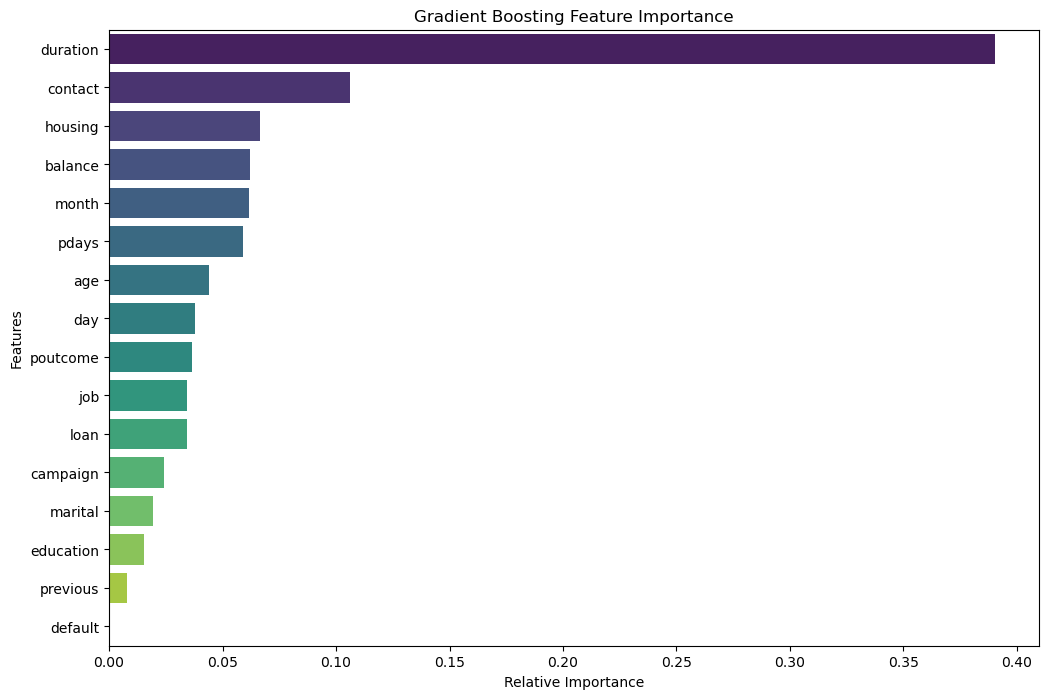

In [33]:
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = np.array(df.columns[:-1])

    plt.figure(figsize=(12, 8))
    sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")
    plt.title(f'{best_model_name} Feature Importance')
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.show()


# Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1206
           1       0.92      0.96      0.94      1194

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400



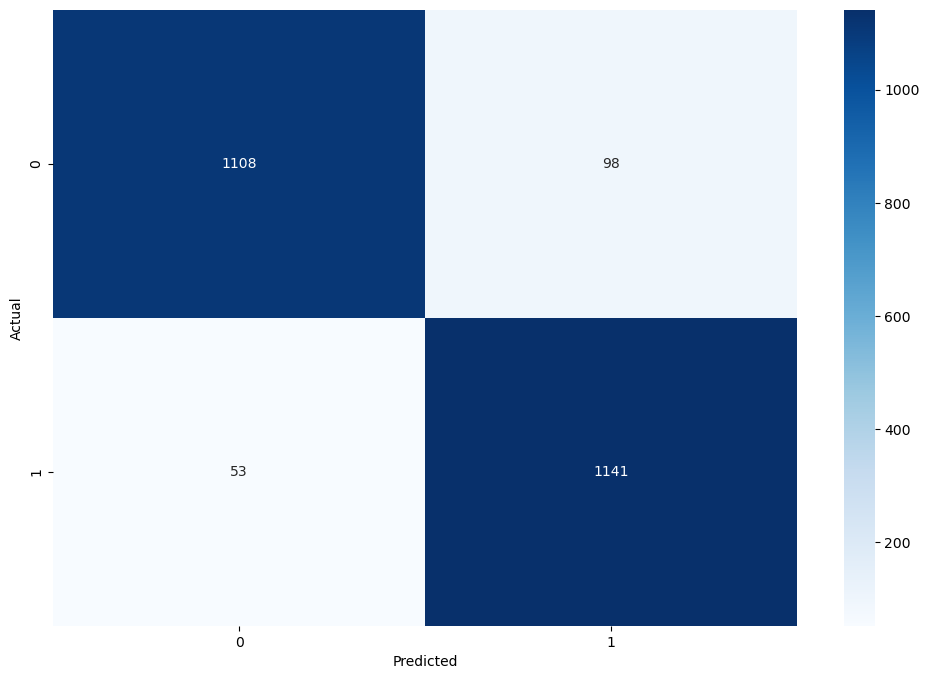

In [34]:
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Predicton - 1

In [35]:
new_data_dict = {
    'age': 70,
    'job': 'management',
    'marital': 'divorced',
    'education': 'primary',
    'default': 'no',
    'balance': 229,
    'housing': 'no',
    'loan': 'no',
    'contact': 'telephone',
    'day': 22,
    'month': 'oct',
    'duration': 300,
    'campaign': 1,
    'pdays': -1,
    'previous': 0,
    'poutcome': 'unknown'
}

new_data_df = pd.DataFrame([new_data_dict])


for column, le in label_encoders.items():
    if column in new_data_df.columns:
        new_data_df[column] = le.transform(new_data_df[column])


new_data_scaled = scaler.transform(new_data_df)


prediction = best_model.predict(new_data_scaled)
# print(f"\nPredicted Credit Score using {best_model_name}: {prediction[0]}")
print("Credit Worthy: Yes" if prediction[0] == 1 else "Credit Worthy: No")

Credit Worthy: Yes


# Prediction-2

In [36]:

new_data_dict = {
    'age': 42,
    'job': 'management',
    'marital': 'divorced',
    'education': 'primary',
    'default': 'no',
    'balance': 229,
    'housing': 'no',
    'loan': 'yes',
    'contact': 'telephone',
    'day': 10,
    'month': 'oct',
    'duration': 90,
    'campaign': 1,
    'pdays': -1,
    'previous': 0,
    'poutcome': 'unknown'
}


new_data_df = pd.DataFrame([new_data_dict])

# Encoding the new data with the same label encoders used for the training data
for column, le in label_encoders.items():
    if column in new_data_df.columns:
        new_data_df[column] = le.transform(new_data_df[column])


new_data_scaled = scaler.transform(new_data_df)

prediction = best_model.predict(new_data_scaled)
# print(f"\nPredicted Credit Score using {best_model_name}: {prediction[0]}")
print("Credit Worthy: Yes" if prediction[0] == 1 else "Credit Worthy: No")

Credit Worthy: Yes
